In [1]:
import keras
import tensorflow as tf
tf.keras.backend.clear_session()
from keras.models import Sequential
from keras import layers
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Bidirectional, Dense

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file_path = input("Enter the path to the CSV file: ")
dataset = pd.read_csv(file_path, header=0, encoding='Latin', engine='python')
#dataset= pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv",header = 0, encoding = 'Latin', engine = 'python')
dataset.head()

Enter the path to the CSV file: /content/drive/MyDrive/IMDB Dataset.csv


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
dataset['sentiment'] = dataset['sentiment'].replace('positive', 1)
dataset['sentiment'] = dataset['sentiment'].replace('negative', 0)

In [8]:
glovepathinput = input("Enter the path to the gloVe file: ")
glove_path = glovepathinput

Enter the path to the gloVe file: /content/drive/MyDrive/glove.6B.100d.txt


In [9]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [10]:
x = dataset['review']
y = dataset['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1000)

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(x_train[2])
print(X_train_seq[2])

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.
[5, 94, 3, 19, 34839, 1, 18771, 2, 1, 144, 326, 1671, 2515, 59, 6982, 57,

In [12]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(glove_path,tokenizer.word_index, embedding_dim)

In [13]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.6250912002847229

In [14]:
from keras import backend as K
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = K.clip(true_positives / (predicted_positives + K.epsilon()), 0, 1)
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = K.clip(true_positives / (possible_positives + K.epsilon()), 0, 1)
    return recall

def f1score_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = K.clip(true_positives / (possible_positives + K.epsilon()), 0, 1)

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = K.clip(true_positives / (predicted_positives + K.epsilon()), 0, 1)

    if precision + recall == 0:
        f1_score = K.constant(0)
    else:
        f1_score = K.clip(2 * (precision * recall) / (precision + recall), 0, 1)

    return f1_score


In [15]:
batch_sizes_to_try = [16, 32, 64, 128, 256]
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)
for batch_size in batch_sizes_to_try:
    print(f"\nTraining with batch size: {batch_size}")


    shallow_model = Sequential()
    shallow_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=False))
    shallow_model.add(Dense(10, activation='relu'))
    shallow_model.add(Dense(1, activation='sigmoid'))
    shallow_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    history = shallow_model.fit(X_train_pad, y_train, epochs=20, batch_size=batch_size, validation_split=0.1, verbose=0)

    # Evaluate
    loss, accuracy = shallow_model.evaluate(X_test_pad, y_test)
    print(f'Test Accuracy (Batch Size {batch_size}): {accuracy * 100:.2f}%')


Training with batch size: 16
313/313 [==============================] - 1s 3ms/step - loss: 0.6828 - accuracy: 0.5456
Test Accuracy (Batch Size 16): 54.56%

Training with batch size: 32
313/313 [==============================] - 1s 3ms/step - loss: 0.6827 - accuracy: 0.5470
Test Accuracy (Batch Size 32): 54.70%

Training with batch size: 64
313/313 [==============================] - 1s 3ms/step - loss: 0.6834 - accuracy: 0.5439
Test Accuracy (Batch Size 64): 54.39%

Training with batch size: 128
313/313 [==============================] - 1s 3ms/step - loss: 0.6832 - accuracy: 0.5465
Test Accuracy (Batch Size 128): 54.65%

Training with batch size: 256
313/313 [==============================] - 1s 3ms/step - loss: 0.6841 - accuracy: 0.5427
Test Accuracy (Batch Size 256): 54.27%


In [16]:
model = Sequential()
maxlen = 100
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen,  trainable=True))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',precision_m,recall_m,f1score_m])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          11239000  
                                                                 
 dense_10 (Dense)            (None, 100, 10)           1010      
                                                                 
 dense_11 (Dense)            (None, 100, 1)            11        
                                                                 
Total params: 11240021 (42.88 MB)
Trainable params: 11240021 (42.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
max_length = 100

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)
model.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
1125/1125 [==============================] - 45s 39ms/step - loss: 0.6853 - accuracy: 0.5457 - precision_m: 0.5393 - recall_m: 0.9991 - f1score_m: 0.6957 - val_loss: 0.6793 - val_accuracy: 0.5552 - val_precision_m: 0.5491 - val_recall_m: 1.0000 - val_f1score_m: 0.7048
Epoch 2/20
1125/1125 [==============================] - 12s 11ms/step - loss: 0.6762 - accuracy: 0.5582 - precision_m: 0.5477 - recall_m: 1.0000 - f1score_m: 0.7034 - val_loss: 0.6781 - val_accuracy: 0.5568 - val_precision_m: 0.5486 - val_recall_m: 1.0000 - val_f1score_m: 0.7044
Epoch 3/20
1125/1125 [==============================] - 9s 8ms/step - loss: 0.6732 - accuracy: 0.5613 - precision_m: 0.5488 - recall_m: 1.0000 - f1score_m: 0.7043 - val_loss: 0.6786 - val_accuracy: 0.5550 - val_precision_m: 0.5437 - val_recall_m: 1.0000 - val_f1score_m: 0.7003
Epoch 4/20
1125/1125 [==============================] - 9s 8ms/step - loss: 0.6710 - accuracy: 0.5635 - precision_m: 0.5502 - recall_m: 1.0000 - f1score_m: 0.7054

In [18]:
shallow_evaluation = model.evaluate(X_train_pad, y_train)
print("Training:")
metric_names = model.metrics_names


for metric_name, metric_value in zip(metric_names, shallow_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

shallow_evaluation = model.evaluate(X_test_pad, y_test)
print("Testing:")
metric_names = model.metrics_names


for metric_name, metric_value in zip(metric_names, shallow_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

1250/1250 [==============================] - 3s 3ms/step - loss: 0.6641 - accuracy: 0.5716 - precision_m: 0.5601 - recall_m: 1.0000 - f1score_m: 0.7137
Training:
Loss: 0.6640837788581848
Accuracy: 0.5715804696083069
Precision_m: 0.5600994229316711
Recall_m: 1.0
F1score_m: 0.71368408203125
313/313 [==============================] - 1s 3ms/step - loss: 0.6890 - accuracy: 0.5567 - precision_m: 0.5424 - recall_m: 1.0000 - f1score_m: 0.6987
Testing:
Loss: 0.689048171043396
Accuracy: 0.55666184425354
Precision_m: 0.542392909526825
Recall_m: 1.0
F1score_m: 0.6987027525901794


In [ ]:
#LSTM

In [26]:
model_lstm_uni = Sequential()
model_lstm_uni.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_lstm_uni.add(LSTM(10))
model_lstm_uni.add(Dense(1, activation='sigmoid'))
model_lstm_uni.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          11239000  
                                                                 
 lstm_2 (LSTM)               (None, 10)                4440      
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 11243451 (42.89 MB)
Trainable params: 4451 (17.39 KB)
Non-trainable params: 11239000 (42.87 MB)
_________________________________________________________________


In [27]:
model_lstm_uni.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1score_m])
model_lstm_uni.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
1125/1125 [==============================] - 11s 8ms/step - loss: 0.5357 - accuracy: 0.7213 - precision_m: 0.7331 - recall_m: 0.7237 - f1score_m: 0.7116 - val_loss: 0.4648 - val_accuracy: 0.7810 - val_precision_m: 0.7380 - val_recall_m: 0.8704 - val_f1score_m: 0.7952
Epoch 2/20
1125/1125 [==============================] - 8s 7ms/step - loss: 0.4335 - accuracy: 0.8008 - precision_m: 0.8064 - recall_m: 0.8003 - f1score_m: 0.7956 - val_loss: 0.4113 - val_accuracy: 0.8138 - val_precision_m: 0.7952 - val_recall_m: 0.8457 - val_f1score_m: 0.8158
Epoch 3/20
1125/1125 [==============================] - 8s 7ms/step - loss: 0.4022 - accuracy: 0.8145 - precision_m: 0.8186 - recall_m: 0.8138 - f1score_m: 0.8096 - val_loss: 0.4031 - val_accuracy: 0.8158 - val_precision_m: 0.7832 - val_recall_m: 0.8718 - val_f1score_m: 0.8216
Epoch 4/20
1125/1125 [==============================] - 8s 8ms/step - loss: 0.3863 - accuracy: 0.8245 - precision_m: 0.8289 - recall_m: 0.8241 - f1score_m: 0.8193 - 

In [28]:
lstm_uni_evaluation = model_lstm_uni.evaluate(X_train_pad, y_train)
print("Training")
metric_names = model_lstm_uni.metrics_names
for metric_name, metric_value in zip(metric_names, lstm_uni_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

lstm_uni_evaluation = model_lstm_uni.evaluate(X_test_pad, y_test)
print("Testing")
metric_names = model_lstm_uni.metrics_names
for metric_name, metric_value in zip(metric_names, lstm_uni_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

1250/1250 [==============================] - 6s 4ms/step - loss: 0.2796 - accuracy: 0.8797 - precision_m: 0.9063 - recall_m: 0.8479 - f1score_m: 0.8724
Training
Loss: 0.27956387400627136
Accuracy: 0.8796749711036682
Precision_m: 0.9063313603401184
Recall_m: 0.8479496240615845
F1score_m: 0.8724069595336914
313/313 [==============================] - 3s 7ms/step - loss: 0.3519 - accuracy: 0.8411 - precision_m: 0.8603 - recall_m: 0.8114 - f1score_m: 0.8304
Testing
Loss: 0.35185399651527405
Accuracy: 0.8410999774932861
Precision_m: 0.8602898716926575
Recall_m: 0.811411440372467
F1score_m: 0.8303547501564026


In [22]:
#Bidirectional
model_lstm_bi = Sequential()
model_lstm_bi.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_lstm_bi.add(Bidirectional(LSTM(10)))
model_lstm_bi.add(Dense(1, activation='sigmoid'))
model_lstm_bi.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          11239000  
                                                                 
 bidirectional (Bidirection  (None, 20)                8880      
 al)                                                             
                                                                 
 dense_13 (Dense)            (None, 1)                 21        
                                                                 
Total params: 11247901 (42.91 MB)
Trainable params: 8901 (34.77 KB)
Non-trainable params: 11239000 (42.87 MB)
_________________________________________________________________


In [23]:
model_lstm_bi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',precision_m, recall_m, f1score_m])
model_lstm_bi.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
1125/1125 [==============================] - 16s 12ms/step - loss: 0.5323 - accuracy: 0.7262 - precision_m: 0.7406 - recall_m: 0.7146 - f1score_m: 0.7107 - val_loss: 0.4384 - val_accuracy: 0.8012 - val_precision_m: 0.7923 - val_recall_m: 0.8186 - val_f1score_m: 0.8007
Epoch 2/20
1125/1125 [==============================] - 12s 11ms/step - loss: 0.4255 - accuracy: 0.8043 - precision_m: 0.8083 - recall_m: 0.8064 - f1score_m: 0.7999 - val_loss: 0.3954 - val_accuracy: 0.8232 - val_precision_m: 0.8215 - val_recall_m: 0.8262 - val_f1score_m: 0.8203
Epoch 3/20
1125/1125 [==============================] - 12s 11ms/step - loss: 0.3879 - accuracy: 0.8251 - precision_m: 0.8276 - recall_m: 0.8280 - f1score_m: 0.8214 - val_loss: 0.3806 - val_accuracy: 0.8330 - val_precision_m: 0.8582 - val_recall_m: 0.7978 - val_f1score_m: 0.8230
Epoch 4/20
1125/1125 [==============================] - 13s 11ms/step - loss: 0.3625 - accuracy: 0.8379 - precision_m: 0.8383 - recall_m: 0.8407 - f1score_m: 0.

In [24]:
lstm_bi_evaluation = model_lstm_bi.evaluate(X_train_pad, y_train)
print("Traning")
metric_names = model_lstm_bi.metrics_names
for metric_name, metric_value in zip(metric_names, lstm_bi_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

lstm_bi_evaluation = model_lstm_bi.evaluate(X_test_pad, y_test)
print("Testing")
metric_names = model_lstm_bi.metrics_names
for metric_name, metric_value in zip(metric_names, lstm_bi_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

1250/1250 [==============================] - 8s 6ms/step - loss: 0.2228 - accuracy: 0.9099 - precision_m: 0.9173 - recall_m: 0.9016 - f1score_m: 0.9068
Traning
Loss: 0.22280535101890564
Accuracy: 0.909850001335144
Precision_m: 0.9172869920730591
Recall_m: 0.9016001224517822
F1score_m: 0.9068063497543335
313/313 [==============================] - 2s 5ms/step - loss: 0.3634 - accuracy: 0.8474 - precision_m: 0.8485 - recall_m: 0.8398 - f1score_m: 0.8399
Testing
Loss: 0.36337852478027344
Accuracy: 0.8474000096321106
Precision_m: 0.8484530448913574
Recall_m: 0.8397620320320129
F1score_m: 0.8398622870445251


In [ ]:
#Comparison

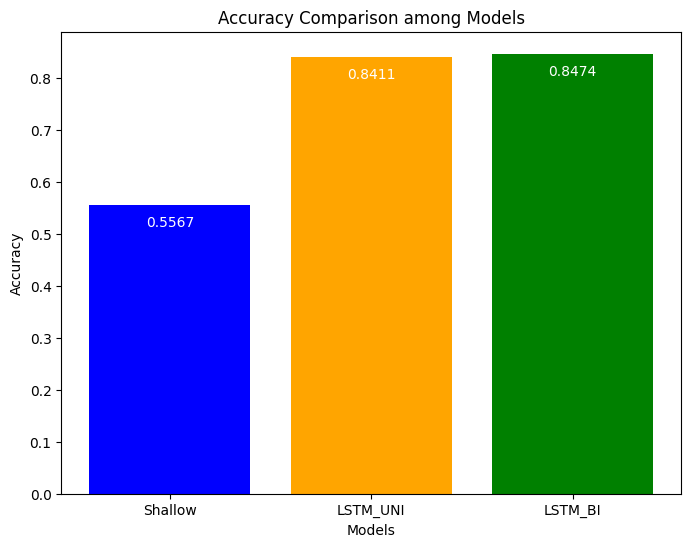

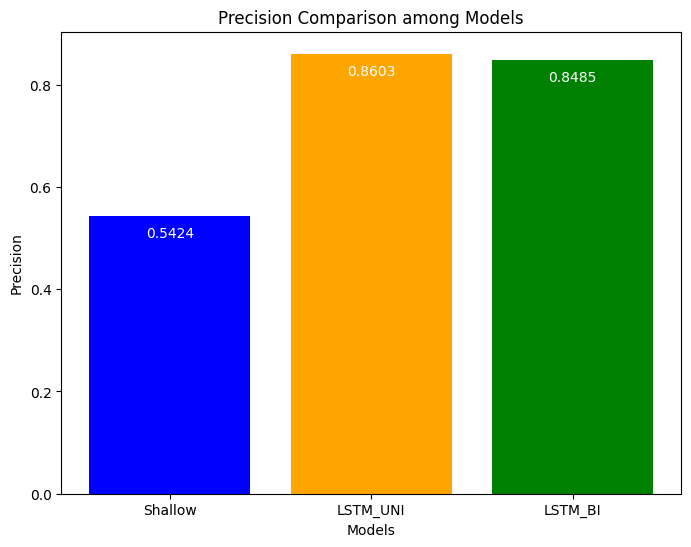

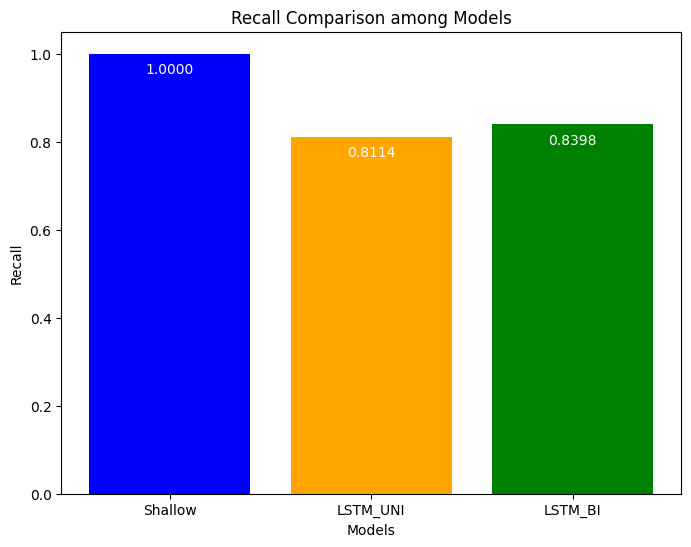

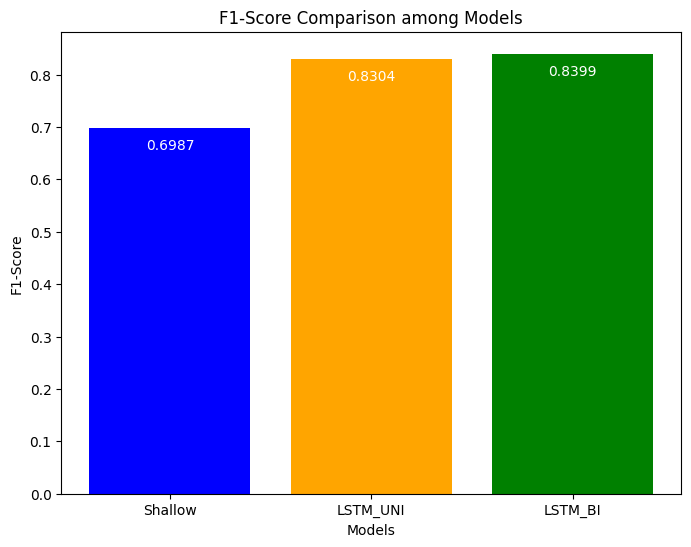

In [29]:
models = ['Shallow', 'LSTM_UNI', 'LSTM_BI']
accuracy = [shallow_evaluation[1], lstm_uni_evaluation[1], lstm_bi_evaluation[1]]
precision = [shallow_evaluation[2], lstm_uni_evaluation[2], lstm_bi_evaluation[2]]
recall = [shallow_evaluation[3], lstm_uni_evaluation[3], lstm_bi_evaluation[3]]
f1_score = [shallow_evaluation[4], lstm_uni_evaluation[4], lstm_bi_evaluation[4]]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_values = [accuracy, precision, recall, f1_score]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 6))
    bars = plt.bar(models, metric_values[i], color=['blue', 'orange', 'green'])


    for bar, value in zip(bars, metric_values[i]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, f'{value:.4f}', ha='center', va='top', color='white')

    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison among Models')
    plt.show()